In [51]:
from scipy.optimize import nnls
import numpy as np

In [52]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [53]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [54]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pyr', 'pv', 'sst', 'vip', 'contrast'])

In [55]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

# fit som

In [56]:
# we use negative values to indicate inhibition (and then use non negative least squares)
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)

y = power_law_inv(som_act)


In [57]:
x_som = nnls(A, y)

In [58]:
x_som

(array([0.90247262, 0.        , 0.        , 0.51539458, 0.        ,
        0.3630127 ]),
 0.10177940318206172)

# fit pv

In [59]:
A = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
Is = data['contrast']
A = np.concatenate((A, Is.T), axis=1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(pv_act,)
x_pv = nnls(A, y)

In [60]:
x_pv

(array([0.6267717 , 0.        , 0.49034239, 0.        , 0.00383783,
        0.37665983]),
 0.024222399833674656)

# fit vip

In [61]:
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(vip_act)
x_vip = nnls(A, y)
x_vip

(array([0.61244814, 0.13455959, 0.52075599, 0.        , 0.        ,
        0.64538931]),
 0.10533766332518235)

# fit E

In [12]:
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
Is = data['contrast']
A = np.concatenate((A, Is.T), axis=1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)
y = power_law_inv(e_act)
x_e = nnls(A, y)
x_e

(array([0.85019137, 0.12046141, 0.32576243, 0.        , 0.00194141,
        0.34042947]),
 0.003432758054374357)

# params

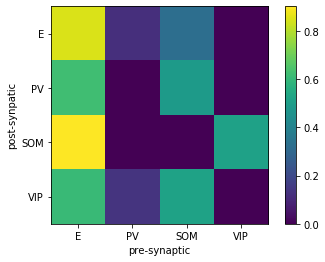

In [13]:
cells = ['E','PV', 'SOM', 'VIP']
W = np.array([x_e[0][:4], x_pv[0][:4], x_som[0][:4], x_vip[0][:4]])
#weight from pv to e
w_ep = x_e[0][1]

import matplotlib.pyplot as plt
plt.imshow(W)
plt.ylabel('post-synpatic')
plt.xlabel('pre-synaptic')
plt.xticks(np.arange(4), cells)
plt.yticks(np.arange(4), cells)
plt.colorbar()

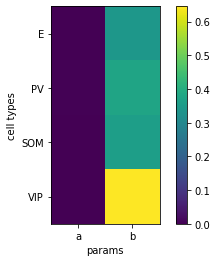

In [14]:

h = np.array([x_e[0][4:], x_pv[0][4:], x_som[0][4:], x_vip[0][4:]])

import matplotlib.pyplot as plt
plt.imshow(h)
plt.ylabel('cell types')
plt.xlabel('params')
plt.xticks(np.arange(2), ['a', 'b'])
plt.yticks(np.arange(4), cells)
plt.colorbar()

In [15]:
h

array([[0.00194141, 0.34042947],
       [0.00383783, 0.37665983],
       [0.        , 0.3630127 ],
       [0.        , 0.64538931]])

## predictions

Text(0.5, 1.0, 'SOM')

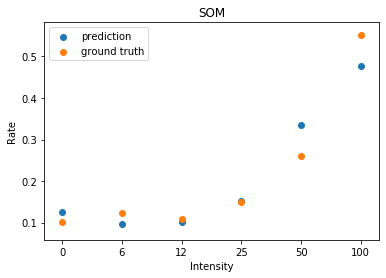

In [40]:
A = np.concatenate((e_act[:,np.newaxis], -1*pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
A = np.concatenate((A, np.zeros((A.shape[0],1))), axis = 1)
A = np.concatenate((A, np.ones((A.shape[0],1))), axis = 1)

Ai = np.concatenate((e_act[:,np.newaxis], -1* pv_act[:,np.newaxis], -1*som_act[:,np.newaxis], -1*vip_act[:,np.newaxis]), axis = 1)
Is = data['contrast']
Ai = np.concatenate((Ai, Is.T), axis=1)
Ai = np.concatenate((Ai, np.ones((A.shape[0],1))), axis = 1)

plt.scatter(range(len(som_act)),power_law_nl(np.dot(A,x_som[0])), label='prediction')
plt.scatter(range(len(som_act)),som_act, label='ground truth')
plt.xlabel('Intensity')
plt.ylabel('Rate')
plt.xticks(range(6),[data['contrast'][0][i] for i in range(6)])
plt.legend()
plt.title('SOM')

Text(0.5, 1.0, 'VIP')

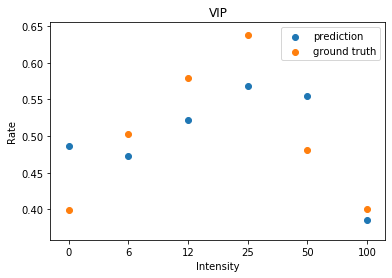

In [44]:
plt.scatter(range(len(vip_act)),power_law_nl(np.dot(A,x_vip[0])), label='prediction')
plt.scatter(range(len(vip_act)),vip_act, label='ground truth')
plt.xlabel('Intensity')
plt.ylabel('Rate')
plt.xticks(range(6),[data['contrast'][0][i] for i in range(6)])
plt.legend()
plt.title('VIP')

Text(0.5, 1.0, 'E')

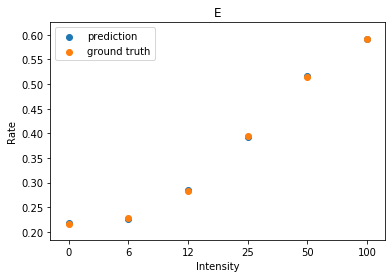

In [47]:
plt.scatter(range(len(e_act)),power_law_nl(np.dot(Ai,x_e[0])), label='prediction')
plt.scatter(range(len(e_act)),e_act, label='ground truth')
plt.xlabel('Intensity')
plt.ylabel('Rate')
plt.xticks(range(6),[data['contrast'][0][i] for i in range(6)])
plt.legend()
plt.title('E')

Text(0.5, 1.0, 'PV')

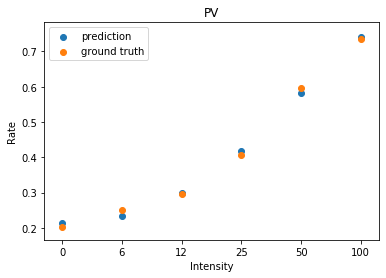

In [48]:
plt.scatter(range(len(pv_act)),power_law_nl(np.dot(Ai,x_pv[0])), label='prediction')
plt.scatter(range(len(pv_act)),pv_act, label='ground truth')
plt.xlabel('Intensity')
plt.ylabel('Rate')
plt.xticks(range(6),[data['contrast'][0][i] for i in range(6)])
plt.legend()
plt.title('PV')

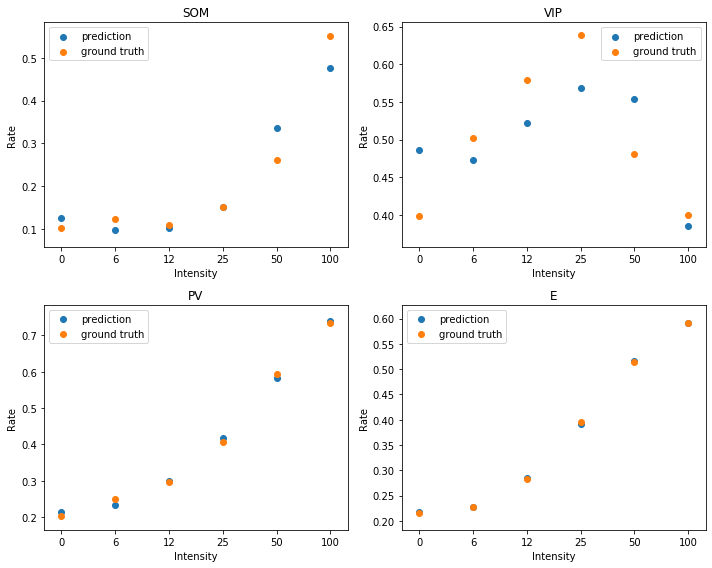

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # Creates a 2x2 grid of subplots

# Titles for each subplot
titles = ['SOM', 'VIP', 'PV', 'E']
acts = [som_act, vip_act, pv_act, e_act]
x = [x_som, x_vip, x_pv, x_e]

# Iterate over each subplot to plot the data
for i, ax in enumerate(axs.flat):
    if i < 2:
        ax.scatter(range(len(som_act)), power_law_nl(np.dot(A, x[i][0])), label='prediction')
        ax.scatter(range(len(som_act)), acts[i], label='ground truth')
    else:
        ax.scatter(range(len(som_act)), power_law_nl(np.dot(Ai, x[i][0])), label='prediction')
        ax.scatter(range(len(som_act)), acts[i], label='ground truth')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Rate')
    ax.set_xticks(range(6))
    ax.set_xticklabels([data['contrast'][0][j] for j in range(6)])
    ax.legend()
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

In [ ]:
# also possible to sample mean from distribution